# MNIST Important Pixels
In this notebook a simple feedforward network is built to recognise MNIST images, using Keras. <br> We then try to identify important pixels in the prediction for a given image.

## Part 1: Build the model

### Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

### Import MNIST data from TensorFlow

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)

/Users/richardangell/anaconda3/envs/TensorFlow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Import Keras 

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


### Define model structure

In [5]:
model = Sequential()
model.add(Dense(32, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

In [6]:
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

### Train model

In [7]:
print("training start:", str(datetime.now()))
model.fit(mnist.train.images, 
          mnist.train.labels, 
          epochs = 10, 
          batch_size = 32,
          validation_data = (mnist.validation.images, mnist.validation.labels))
print("training end:", str(datetime.now()))

training start: 2018-01-11 19:17:32.143990
Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 2s 38us/step - loss: 0.3590 - acc: 0.9011 - val_loss: 0.2107 - val_acc: 0.9402
Epoch 2/10
55000/55000 [==============================] - 2s 36us/step - loss: 0.2024 - acc: 0.9415 - val_loss: 0.1712 - val_acc: 0.9538
Epoch 3/10
55000/55000 [==============================] - 2s 35us/step - loss: 0.1673 - acc: 0.9523 - val_loss: 0.1534 - val_acc: 0.9564
Epoch 4/10
55000/55000 [==============================] - 2s 35us/step - loss: 0.1465 - acc: 0.9585 - val_loss: 0.1404 - val_acc: 0.9620
Epoch 5/10
55000/55000 [==============================] - 2s 35us/step - loss: 0.1324 - acc: 0.9628 - val_loss: 0.1386 - val_acc: 0.9624
Epoch 6/10
55000/55000 [==============================] - 2s 36us/step - loss: 0.1219 - acc: 0.9652 - val_loss: 0.1379 - val_acc: 0.9614
Epoch 7/10
55000/55000 [==============================] - 2s 36us/step - loss: 0.1153 

In [8]:
train_preds = model.predict(mnist.train.images)
train_preds.shape

(55000, 10)

### Check model layers

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.get_layer("dense_1").get_weights()[0].shape

(784, 32)

In [11]:
model.get_layer("dense_1").get_weights()[1].shape

(32,)

In [12]:
model.get_layer("dense_2").get_weights()[0].shape

(32, 10)

In [13]:
model.get_layer("dense_2").get_weights()[1].shape

(10,)

## Part 2: Find important pixels for the predicted value of a given image

### Choose image to consider
For the first row of training data, plot the image (7) and get the predictions from the model. <br> Predicted probability for class 7 = 93%.

In [7]:
row_number = 0

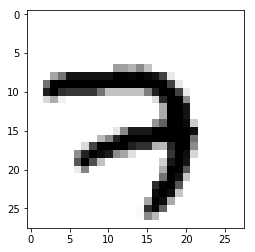

In [75]:
plt.imshow(1 - mnist.train.images[row_number,].reshape(28, 28), cmap='gray')

In [16]:
print(mnist.train.labels[row_number])
print("label:" , np.dot(mnist.train.labels[row_number], np.arange(10)))

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
label: 7.0


In [17]:
np.round(train_preds[row_number], 2)

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

### Mulitply inputs (pixel values) by layer 1 weights 
For the first image, get pixel value * weight for each node (32) in layer 1.

In [15]:
def multiply_inputs_coefs(inputs, coefs):
    print("inputs shape:", inputs.shape)
    print("coefs shape:", coefs.shape)
    outputs = np.multiply(inputs, coefs)
    print("outputs shape:", outputs.shape)
    return(outputs)

In [19]:
input_x_coef1 = multiply_inputs_coefs(mnist.train.images[row_number,],
                                      np.transpose(model.get_layer("dense_1").get_weights()[0]))

inputs shape: (784,)
coefs shape: (32, 784)
outputs shape: (32, 784)


### Get intermediate layer outputs
These will be needed in the next section.

In [19]:
from keras.models import Model

In [21]:
layer_name = 'activation_1'
intermediate_layer_model = Model(inputs = model.input,
                                 outputs = model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(mnist.train.images)
intermediate_output.shape

(55000, 32)

### Multiply layer 1 outputs by layer 2 weights
Now multiply the outputs from the activation_1 layer with the weights from the second dense layer, for each node (10).

In [22]:
intermediate_output[0,].shape

(32,)

In [23]:
intermediate_output.shape

(55000, 32)

In [24]:
input_x_coef2 = multiply_inputs_coefs(intermediate_output[row_number,],
                                      np.transpose(model.get_layer("dense_2").get_weights()[0]))

inputs shape: (32,)
coefs shape: (10, 32)
outputs shape: (10, 32)


In [25]:
pd.set_option('display.max_columns', 20)
pd.DataFrame(input_x_coef2)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,-1.038059,-0.0,0.048382,-0.0,0.0,-0.0,-0.0,-0.395925,0.0,-5.556104,...,0.0,-0.0,-1.254945,-0.0,-0.0,-0.160280,-0.0,0.165583,-0.0,-0.005243
1,-1.667265,-0.0,-4.527611,-0.0,0.0,-0.0,-0.0,0.272612,-0.0,0.263139,...,-0.0,-0.0,1.248842,0.0,-0.0,-0.139885,0.0,-0.946494,0.0,-0.153607
2,-0.589613,0.0,-1.353158,-0.0,-0.0,-0.0,-0.0,-0.011784,0.0,-1.683522,...,-0.0,0.0,0.535700,-0.0,0.0,0.051014,-0.0,-0.570942,-0.0,0.002796
3,-0.011569,-0.0,1.029965,-0.0,-0.0,-0.0,-0.0,0.085604,-0.0,0.002077,...,-0.0,-0.0,0.850595,0.0,-0.0,-0.142918,-0.0,-0.455111,-0.0,-0.253116
4,0.661668,0.0,-0.843989,-0.0,-0.0,0.0,0.0,-0.591405,-0.0,-0.767890,...,0.0,-0.0,-0.366399,-0.0,-0.0,0.015492,0.0,-0.213707,0.0,0.044080
5,-0.076256,-0.0,-3.058671,-0.0,-0.0,-0.0,0.0,0.047731,-0.0,-3.650860,...,-0.0,0.0,-3.824978,-0.0,-0.0,-0.176371,-0.0,-0.099878,0.0,-0.305837
6,0.060964,0.0,1.048620,-0.0,0.0,0.0,0.0,-0.211510,-0.0,-2.699333,...,-0.0,-0.0,-3.643256,-0.0,0.0,-0.046626,0.0,-0.269945,0.0,-0.395299
7,-2.542858,-0.0,-0.478608,-0.0,-0.0,-0.0,-0.0,-0.726055,-0.0,1.632090,...,0.0,-0.0,-0.909822,-0.0,-0.0,-0.000013,-0.0,-0.380399,-0.0,-0.036776
8,0.760713,-0.0,0.324053,0.0,-0.0,-0.0,-0.0,0.286719,-0.0,0.186730,...,-0.0,-0.0,-1.540953,-0.0,-0.0,-0.067049,-0.0,-0.177100,-0.0,0.079304
9,-1.071790,-0.0,-1.521135,0.0,-0.0,0.0,-0.0,-0.456376,-0.0,1.348584,...,-0.0,-0.0,-0.437205,-0.0,-0.0,0.039222,0.0,0.301589,0.0,-0.053290


### Sum inputs * weights by input for second layer

In [26]:
layer2_sum_input = np.sum(input_x_coef2, axis = 0)
layer2_sum_input

array([ -5.5140634,   0.       ,  -9.332153 ,   0.       ,   0.       ,
         0.       ,   0.       ,  -1.7003876,   0.       , -10.92509  ,
         0.       ,   0.       , -23.525368 , -30.607521 ,   0.       ,
         0.       , -23.89869  , -25.884806 ,   0.       ,   0.       ,
         0.       , -32.01034  ,   0.       ,   0.       ,  -9.342422 ,
         0.       ,   0.       ,  -0.6274145,   0.       ,  -2.646404 ,
         0.       ,  -1.0769885], dtype=float32)

### Multiply weights through network
value for pixel 1 = <br> input.weight(input1, node1) \* \[sum(input.weight(input1, node1), .., input.weight(input1, node10))\] + <br>
input.weight(input1, node2) \* \[sum(input.weight(input2, node1), .., input.weight(input2, node10))\] + <br>
input.weight(input1, node3) \* \[sum(input.weight(input3, node1), .., input.weight(input3, node10))\] + <br>
... <br>
input.weight(input1, node32) \* \[sum(input.weight(input32, node1), .., input.weight(input32, node10))\] <br>
Note, the inputs are nodes within the sum refer to second dense layer.

In [27]:
pixel_weight_network_sum = np.dot(layer2_sum_input, input_x_coef1)
pixel_weight_network_sum.shape

(784,)

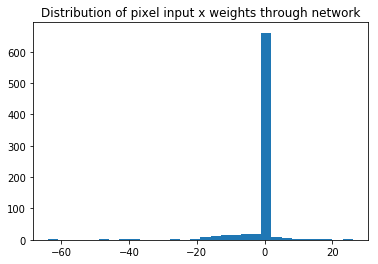

In [28]:
plt.title('Distribution of pixel input x weights through network')
a = plt.hist(pixel_weight_network_sum, bins=30)

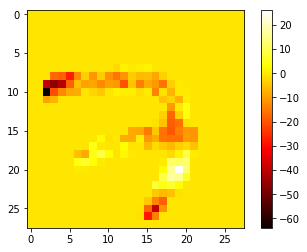

In [29]:
plt.imshow(pixel_weight_network_sum.reshape(28, 28), cmap='hot')
plt.colorbar()

This shows the product of input * weight through the network, starting at each pixel. <br>
However given that the background for the images is white, these zero values propagate through the network, and hence we are just highlighting the non-background (zero) pixels. <br> Need to test this on a different dataset where the background is not all one colour.

### Look at softmax transformation
First get output from second dense layer before going into the softmax function.

In [30]:
layer_name = 'dense_2'
intermediate_layer_model = Model(inputs = model.input,
                                 outputs = model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(mnist.train.images)
intermediate_output.shape

(55000, 10)

In [31]:
np.round(intermediate_output[0], 2)

array([-25.95, -24.75,  -5.08,  -5.16, -23.14, -25.45, -31.05,   2.26,
       -24.86, -15.36], dtype=float32)

From https://stackoverflow.com/a/38250088;

In [32]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

In [33]:
np.round(softmax(intermediate_output[0]), 2)

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

The large negative values output from the second dense layer are transformed to 0 through the softmax function. <br> This is a multiclass classification problem. <br> Negative "network weights" are mainly highlighted in the image. <br> Should just consider the path through the network from the pixel to the predicted class **which is not what is done above**.

### Save model

model.save(os.getcwd() + "/Models/2018-01-09_MNIST-Important-Pixels_White-Background.h5")

## Part 3. Change white background to noise and train another model

### Replace background with noise

In [4]:
background_noise_train = mnist.train.images.copy()
background_noise_train.shape

(55000, 784)

In [5]:
np.random.seed(1)
noise = np.random.rand(55000, 784)
noise[background_noise_train != 0] = 0
background_noise_train = background_noise_train + noise

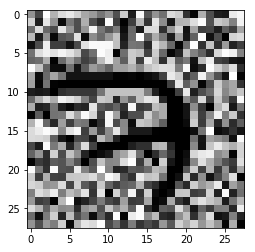

In [8]:
plt.imshow(1 - background_noise_train[row_number,].reshape(28, 28), cmap='gray')

### Rebuild model

In [9]:
model2 = Sequential()
model2.add(Dense(64, input_shape=(784,)))
model2.add(Activation('relu'))
model2.add(Dense(10))
model2.add(Activation('softmax'))

In [10]:
model2.compile(optimizer = 'rmsprop',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [11]:
print("training start:", str(datetime.now()))
model2.fit(background_noise_train, 
           mnist.train.labels, 
           epochs = 30, 
           batch_size = 32)
print("training end:", str(datetime.now()))

training start: 2018-01-11 19:54:16.174016
Epoch 1/30
55000/55000 [==============================] - 2s 43us/step - loss: 1.1539 - acc: 0.6219
Epoch 2/30
55000/55000 [==============================] - 2s 40us/step - loss: 0.7700 - acc: 0.7511
Epoch 3/30
55000/55000 [==============================] - 2s 39us/step - loss: 0.7243 - acc: 0.7673
Epoch 4/30
55000/55000 [==============================] - 2s 40us/step - loss: 0.6996 - acc: 0.7737
Epoch 5/30
55000/55000 [==============================] - 2s 40us/step - loss: 0.6790 - acc: 0.7818
Epoch 6/30
55000/55000 [==============================] - 2s 39us/step - loss: 0.6590 - acc: 0.7882
Epoch 7/30
55000/55000 [==============================] - 2s 40us/step - loss: 0.6384 - acc: 0.7922
Epoch 8/30
55000/55000 [==============================] - 2s 40us/step - loss: 0.6166 - acc: 0.7998
Epoch 9/30
55000/55000 [==============================] - 2s 40us/step - loss: 0.5941 - acc: 0.8067
Epoch 10/30
55000/55000 [==============================] 

We're getting much worse accuracy, but let's leave it at that for now.

In [12]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [13]:
train_preds2 = model2.predict(background_noise_train)
train_preds2.shape

(55000, 10)

### Calculate pixel importance

In [17]:
input_x_coef12 = multiply_inputs_coefs(background_noise_train[row_number,],
                                       np.transpose(model2.get_layer("dense_1").get_weights()[0]))

inputs shape: (784,)
coefs shape: (64, 784)
outputs shape: (64, 784)


In [20]:
layer_name = 'activation_1'
intermediate_layer_model2 = Model(inputs = model2.input,
                                  outputs = model2.get_layer(layer_name).output)
intermediate_output2 = intermediate_layer_model2.predict(background_noise_train)
intermediate_output2.shape

(55000, 64)

In [22]:
input_x_coef22 = multiply_inputs_coefs(intermediate_output2[row_number,],
                                       np.transpose(model2.get_layer("dense_2").get_weights()[0]))

inputs shape: (64,)
coefs shape: (10, 64)
outputs shape: (10, 64)


In [23]:
layer2_sum_input2 = np.sum(input_x_coef22, axis = 0)

In [24]:
pixel_weight_network_sum2 = np.dot(layer2_sum_input2, input_x_coef12)
pixel_weight_network_sum2.shape

(784,)

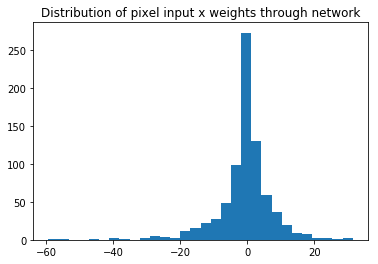

In [25]:
plt.title('Distribution of pixel input x weights through network')
a = plt.hist(pixel_weight_network_sum2, bins=30)

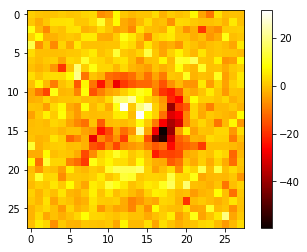

In [26]:
plt.imshow(pixel_weight_network_sum2.reshape(28, 28), cmap='hot')
plt.colorbar()

In [27]:
np.round(train_preds2[0], 2)

array([0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.  , 0.82, 0.  , 0.16],
      dtype=float32)

### Check importance for class 7 prediction only

In [29]:
input_x_coef23 = multiply_inputs_coefs(intermediate_output2[row_number,],
                                       np.transpose(model2.get_layer("dense_2").get_weights()[0])[7,])

inputs shape: (64,)
coefs shape: (64,)
outputs shape: (64,)


In [30]:
layer2_sum_input3 = input_x_coef23
layer2_sum_input3.shape

(64,)

In [31]:
pixel_weight_network_sum3 = np.dot(layer2_sum_input3, input_x_coef12)
pixel_weight_network_sum3.shape

(784,)

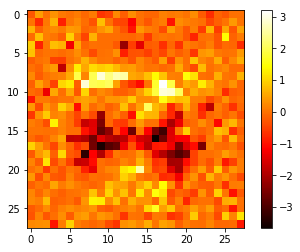

In [32]:
plt.imshow(pixel_weight_network_sum3.reshape(28, 28), cmap='hot')
plt.colorbar()

None of these are particularly clear but the model is performing much worse and is much less confident in the prediction for this particular class.